In [14]:
import warnings

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.plotting import clustered_scatterplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import (
    align_patch,
    find_optimal_clustering_angle,
)
from hdbscan import HDBSCAN


pv.set_jupyter_backend("static")

scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}


df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_filtered_small.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}

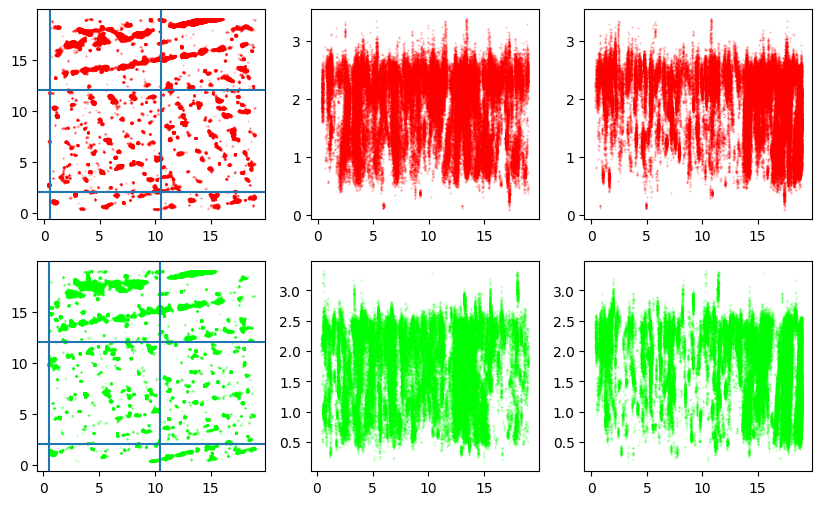

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

bbox = BoundingSquare(0.5, 2, side=10)

for ax in axes[:, 0]:
    ax.axhline(y=bbox.y0)
    ax.axhline(y=bbox.y1)
    ax.axvline(x=bbox.x0)
    ax.axvline(x=bbox.x1)


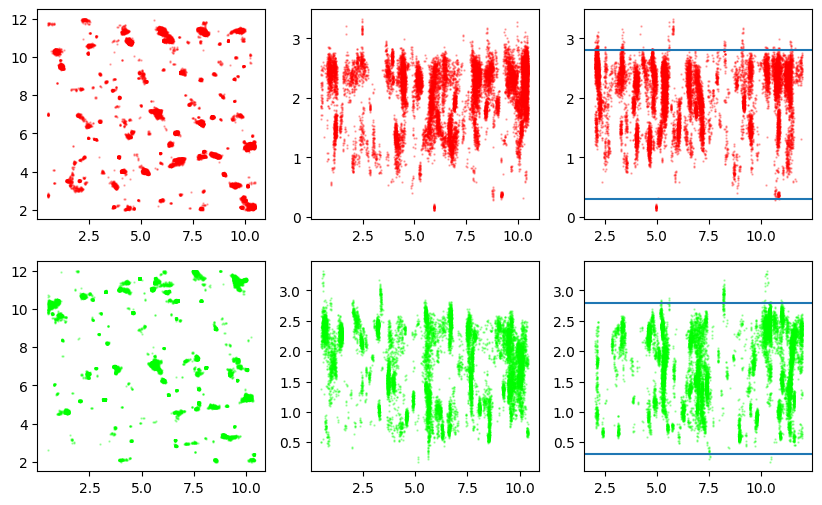

In [4]:
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

scatter_kwargs = {"alpha": 0.3, "s": 0.5}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
    axes[i, -1].axhline(y=0.3)
    axes[i, -1].axhline(y=2.8)

In [5]:
z_min = np.minimum(np.min(sq1["desmin"][:, 2]), np.min(sq1["actinin"][:, 2]))
z_max = np.maximum(np.max(sq1["desmin"][:, 2]), np.max(sq1["actinin"][:, 2]))
z_bin_edges = np.asarray([0.3, 0.9, 1.5, 2.1, 2.8])
print(z_max - z_min)
print(z_bin_edges[1] - z_bin_edges[0])

3.209988726880727
0.6000000000000001


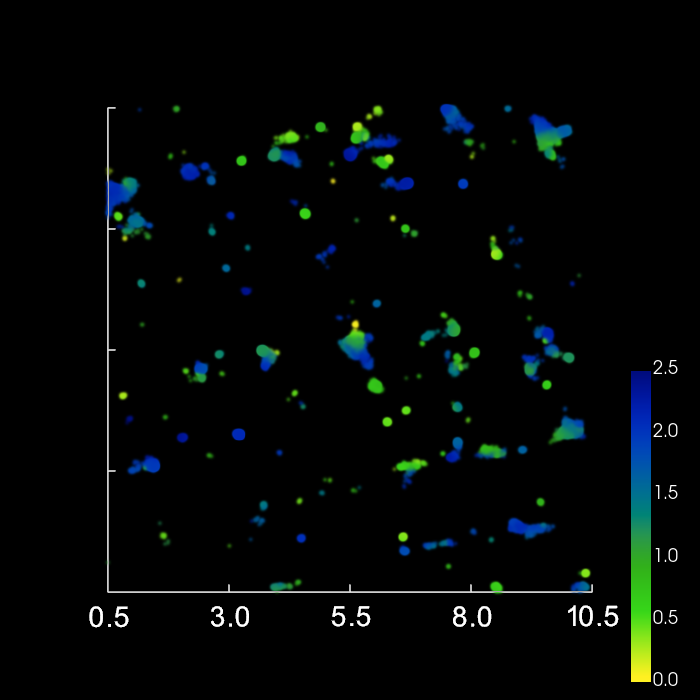

In [49]:
CMAP_DICT = {"desmin": "autumn", "actinin": cc.cm.bgy_r}

p = pv.Plotter(notebook=True, window_size=(700, 700))

protein = "actinin"  # actinin
z_idx = 3  # 1, 2, 3
points_roi = sq1[protein]

idx_in_range = points_roi[:, 2] < z_bin_edges[z_idx + 1]
pts_in_range = points_roi[idx_in_range]

p.set_background(color="black")
p.add_mesh(
    pts_in_range,
    scalars=pts_in_range[:, 2] - 0.3,
    cmap=CMAP_DICT[protein],
    clim=(0.0, 2.5),
    style="points_gaussian",
    point_size=3.0,
    opacity=0.4,
    scalar_bar_args={"vertical": True, "color": "white", "n_labels": 6, "fmt": "%.1f"},
)

axis = p.show_bounds(
    color="white",
    bounds=[0.5, 10.5, 2.0, 12.0, 0.0, 3.0],
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.view_xy()
p.enable_parallel_projection()
if protein == "desmin":
    axis.x_axis_label_visibility = False
if z_idx != 0:
    axis.y_axis_label_visibility = False
p.show()
p.save_graphic(f"../figures/fig_2/2g/{protein}_z_slice={z_idx}.svg")

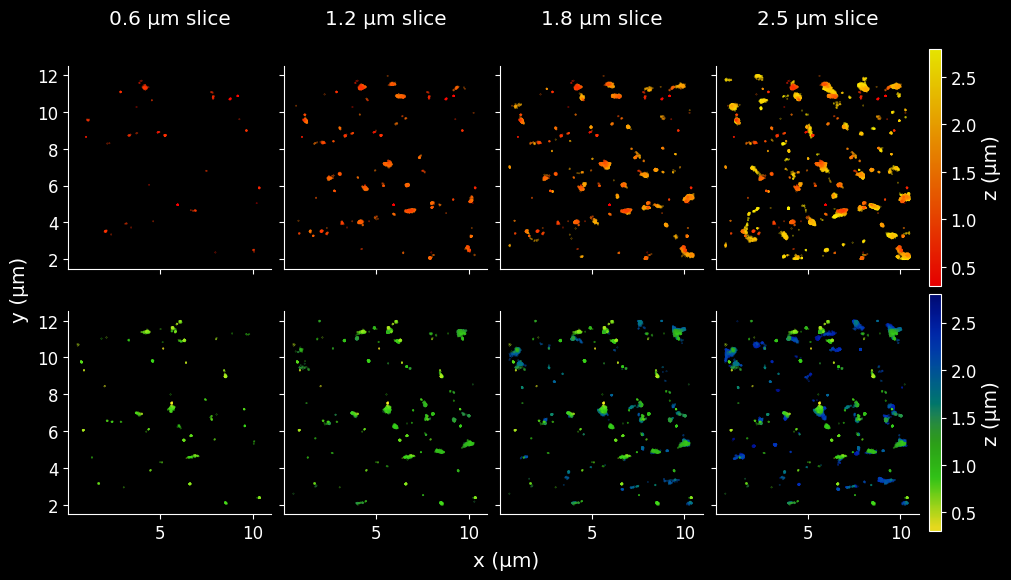

In [ ]:
plt.style.use("dark_background")
plt.rc("font", size=12)
fig, axes = plt.subplots(
    2,
    len(z_bin_edges) - 1,
    figsize=(10, 5.7),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

plots = []
for j in range(len(z_bin_edges) - 1):
    axes[0, j].set_title(f"{z_bin_edges[j + 1] - z_bin_edges[0]:.1f} μm slice", pad=30)

    for i, (protein, pts) in enumerate(sq1.items()):
        idx_in_range = pts[:, 2] < z_bin_edges[j + 1]
        pts_in_range = pts[idx_in_range]

        p = axes[i, j].scatter(
            pts_in_range[:, 0],
            pts_in_range[:, 1],
            marker=".",
            c=pts_in_range[:, 2],
            s=0.2,
            alpha=0.9,
            cmap=CMAP_DICT[protein],
            vmin=0.3,
            vmax=2.8,
        )
        plots.append(p)

    # axes[2, j].scatter(
    #     pts_in_range[:, 0],
    #     pts_in_range[:, 1],
    #     color=COLOR_DICT[protein],
    #     s=0.5,
    #     alpha=0.7,
    # )
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_aspect("equal", "box")

fig.supxlabel("x (μm)")
fig.supylabel("y (μm)")
cbar = fig.colorbar(plots[-2], ax=axes[0, -1])
cbar.ax.set_ylabel("z (μm)", size="large")
cbar = fig.colorbar(plots[-1], ax=axes[1, -1])
cbar.ax.set_ylabel("z (μm)", size="large")

fig.savefig("../figures/fig_2/varying_thickness.svg", dpi=100)

100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


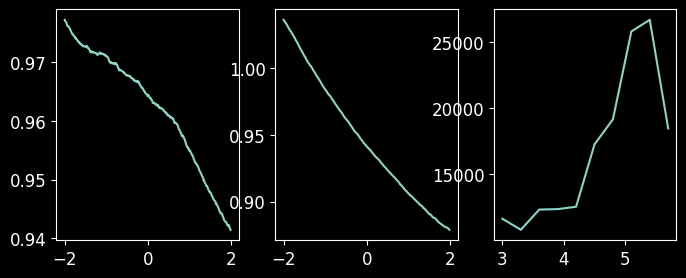

In [7]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform, metrics = transform, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.01),
        rotation_sweep_values=np.arange(3, 6, 0.3),
        min_cluster_size=1000,
        min_samples=5,
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(8, 3))

for i, ax in enumerate(axes):
    ax.plot(*metrics[i])

sq2 = {k: transform(v) for k, v in sq1.items()}

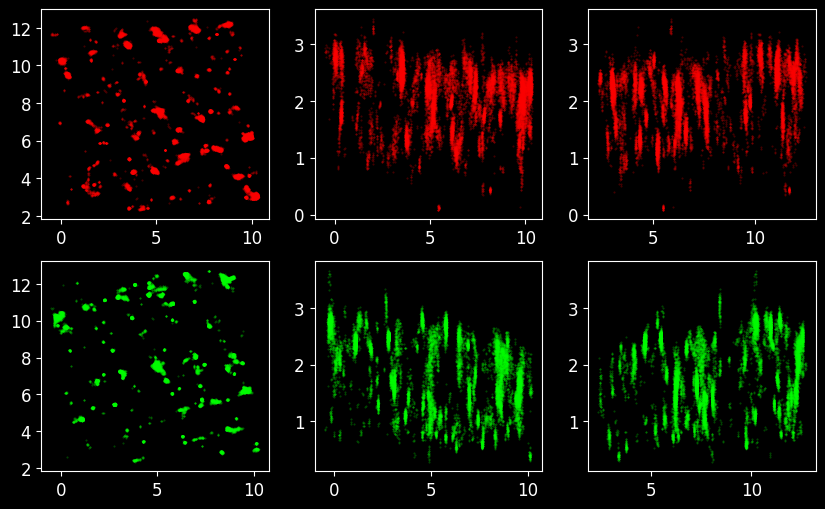

In [8]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq2[protein][:, ax1],
            sq2[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


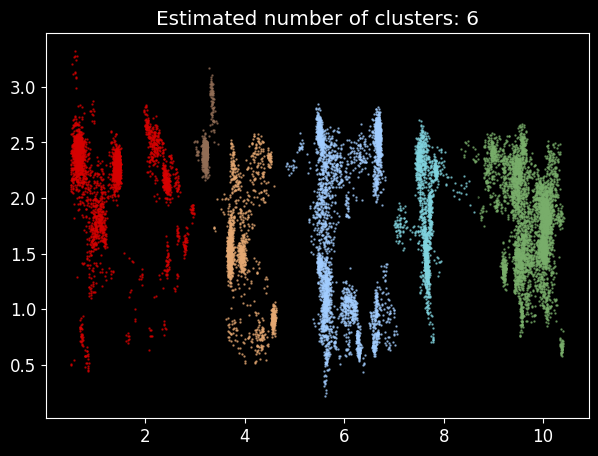

In [9]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=5)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

In [35]:
transform, metric = find_optimal_clustering_angle(
    sq1["actinin"], np.arange(-20, 20, 0.05), min_cluster_size=1500, min_samples=1
)

  0%|          | 0/800 [00:00<?, ?it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/800 [00:00<03:19,  4.01it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

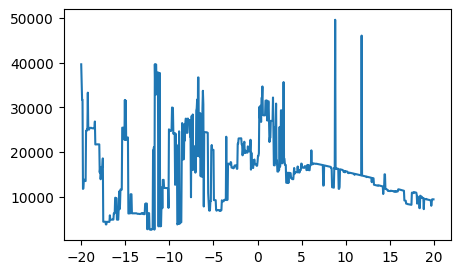

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.arange(-20, 20, 0.05), metric)
sq3 = {k: transform(v) for k, v in sq1.items()}

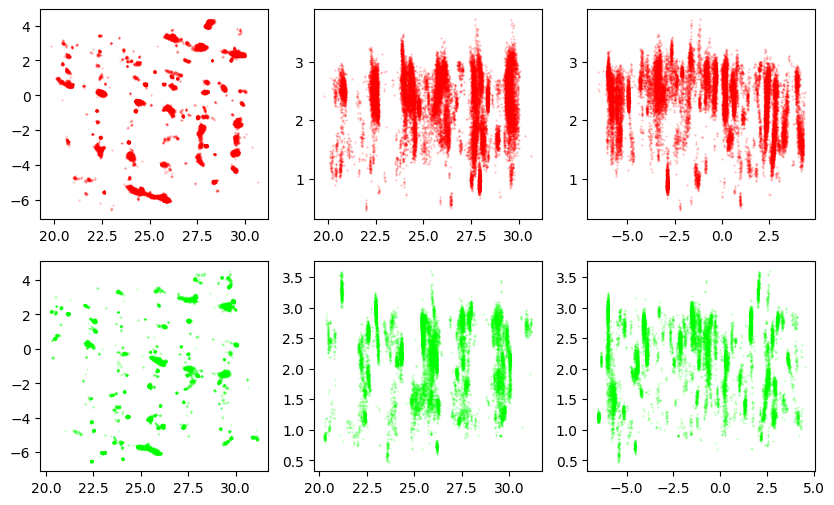

In [38]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq3[protein][:, ax1],
            sq3[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

points_final = {k: transform_fn(v) for k, v in points.items()}


  5%|▍         | 7/150 [01:37<33:11, 13.93s/it]


KeyboardInterrupt: 